In [61]:
from pathlib import Path
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import matplotlib.colors as mcolors
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    auc
)
from functools import wraps
from typing import Iterable

seed = 1234
n_bs = 50
rng = np.random.default_rng(seed)

def bootstrap_metric(metric: callable, rng: np.random.Generator, n_bootstraps: int = 20) -> callable:
    """Bootstrap a metric calculation.

    Args:
        y_true (np.ndarray): True binary labels.
        y_pred_or_probas (np.ndarray): Predicted binary labels or probabilities.
        metric (callable): Metric function to be bootstrapped. Should take y_true and y_pred as arguments.
        threshold (float, optional): Threshold to convert probabilities to binary labels. If None, y_pred_or_probas is assumed to be binary labels. Defaults to None.
        n_bootstraps (int, optional): Number of bootstrap samples. Defaults to 20.

    Returns:
        callable: A function that computes the bootstrapped metric and its 95% confidence interval.
    """
    @wraps(metric)
    def wrapper(y_true: Iterable[int], y_pred_or_probas: Iterable[float | int], threshold: float | None = None, n_bootstraps: int = n_bootstraps, rng: np.random.Generator = rng, *args, **kwargs) -> tuple[float, tuple[float, float]]:
        boot_metrics = []
        n = len(y_true)
        for _ in range(n_bootstraps):
            indices = rng.integers(0, n, n)
            if threshold is not None:
                y_pred_sample = (y_pred_or_probas[indices] >= threshold).astype(int)
            else:
                y_pred_sample = y_pred_or_probas[indices]
            y_true_sample = y_true[indices]
            boot_metric = metric(y_true_sample, y_pred_sample, *args, **kwargs)
            boot_metrics.append(boot_metric)
        boot_metrics = np.array(boot_metrics)
        mean_metric = np.mean(boot_metrics)
        lower_ci = np.percentile(boot_metrics, 2.5)
        upper_ci = np.percentile(boot_metrics, 97.5)
        return mean_metric, (lower_ci, upper_ci)
    return wrapper


def get_shades(color, n_shades=6):
    base_color = mcolors.to_rgba(color)
    return [mcolors.to_hex((base_color[0], base_color[1], base_color[2], base_color[3] * (i / n_shades))) for i in range(1, n_shades + 1)]

filepaths = OmegaConf.load("../configs/filepaths/base.yaml")
mlflow.set_tracking_uri(filepaths.tracking_uri)

discrete_metrics = {
    'f1': bootstrap_metric(f1_score, rng, n_bootstraps=n_bs),
    'binary_precision': bootstrap_metric(precision_score, rng, n_bootstraps=n_bs),
    'binary_recall': bootstrap_metric(recall_score, rng, n_bootstraps=n_bs),
    'accuracy': bootstrap_metric(accuracy_score, rng, n_bootstraps=n_bs),
}

continuous_metrics = {
    'roc_auc': bootstrap_metric(roc_auc_score, rng, n_bootstraps=n_bs),
}

Wrangle top model run ids

In [62]:
top_models = pd.read_csv(Path(filepaths.artifacts) / "250209_top_models.csv", sep=',')
top_cgr = pd.read_csv(Path(filepaths.artifacts) / "250223_top_cgr_models.csv", sep=',')
top_models = pd.concat((top_models, top_cgr), axis=0, ignore_index=True)
top_models.head()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,X_d_transform,batch_norm,...,epoch,train_loss,val/accuracy,val/binary_precision,val/binary_recall,val/f1,val/mcc,val/prc,val/roc,val_loss
0,2025-02-07 13:21:04,3.9h,ff90895a6070499b8fdcdc0982526885,dazzling-rat-180,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.025103,0.809866,0.963687,0.631624,0.762649,0.653961,0.921851,0.912527,0.762649
1,2025-02-07 13:20:39,3.1h,8a155bc5673b4c6aa8667dd55755fe0b,zealous-eel-839,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.002602,0.809679,0.972779,0.624411,0.760160,0.656536,0.959718,0.961152,0.760160
2,2025-02-07 13:20:39,3.1h,5ca6ba7b8aec4b81a366e9138b9c09b0,smiling-colt-432,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.004807,0.797277,0.969662,0.600536,0.741214,0.635536,0.947565,0.949833,0.741214
3,2025-02-07 13:20:35,3.4h,2241478505f9497885d25b9a0dee3ffd,fortunate-panda-724,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.027877,0.950560,0.979499,0.919235,0.948325,0.902712,0.986876,0.986808,0.948325
4,2025-02-07 13:20:33,3.4h,e638683b53f84d0ba1c8f32794413e0e,burly-goat-264,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.044305,0.949125,0.977389,0.918329,0.946844,0.899774,0.984206,0.986065,0.946844


In [63]:
run_ids = top_models['Run ID'].to_list()
print(",".join(run_ids))

ff90895a6070499b8fdcdc0982526885,8a155bc5673b4c6aa8667dd55755fe0b,5ca6ba7b8aec4b81a366e9138b9c09b0,2241478505f9497885d25b9a0dee3ffd,e638683b53f84d0ba1c8f32794413e0e,fb3c7a9061a744fba7dabf9d50092414,4bf93c6830744a4b8e6d8076f14a82e1,ef2ce94281fb445ba304791f991e23cc,3c1ce655b064442cb7789fa210e4caaf,2a7b803f790143f0b14a1955117cb393


In [64]:
best_thresholds = {
    'ff90895a6070499b8fdcdc0982526885': 0.010101010101010102,
    '8a155bc5673b4c6aa8667dd55755fe0b': 0.010101010101010102,
    '5ca6ba7b8aec4b81a366e9138b9c09b0': 0.010101010101010102,
    '2241478505f9497885d25b9a0dee3ffd': 0.15151515151515152,
    'e638683b53f84d0ba1c8f32794413e0e': 0.12121212121212122,
    'fb3c7a9061a744fba7dabf9d50092414': 0.010101010101010102,
    '4bf93c6830744a4b8e6d8076f14a82e1': 0.05050505050505051,
    'ef2ce94281fb445ba304791f991e23cc': 0.26262626262626265,
    '3c1ce655b064442cb7789fa210e4caaf': 0.21212121212121213,
    '2a7b803f790143f0b14a1955117cb393': 0.010101010101010102,
    '84eab00d36354c1bac700bd82b9b222c': 0.25252525252525254,
    'e48cb2b15ee94a3aae6e3b324d3d8aba': 0.17171717171717174,
    'b1f3ce077f454c828d0837acbac7bb6e': 0.26262626262626265,
    'd898b47a73984726bb593a3a19a6b2ec': 0.30303030303030304,
    'f3bbad9576cd45f69569f7914c5a8b18': 0.37373737373737376,
    'd618e5ac38c24e089a5c477dc8902f09': 0.010101010101010102,
    '28ebdae603464197a6ac0ecb38469b6f': 0.010101010101010102,
    '311eda1797af4cfaa2eb7067655a381b': 0.010101010101010102,
    'be7e38c4676e4e5ebc3caf2adcd76ca7': 0.010101010101010102,
    '36bb12690dda4298bccd1a8a63930e53': 0.030303030303030304,
    'a9f2dce71dc041e0a76c1663b5d9b41d': 0.5757575757575758,
    'f43941db95544e59a3e2b584b9aee567': 0.595959595959596,
    '6576cf8c65be40c5a1573685f0727082': 0.14141414141414144,
    '199d3b61c7c1450aa7176fb0735de21e': 0.494949494949495,
    '1e871b45c8bc46fab2da4c233681be3a': 0.38383838383838387,
    '36be3d0aca6d4b42804e6670437da7e4': 0.05050505050505051,
    '412c8627a31b4ba7a40967d344ae4745': 0.05050505050505051,
    '0d61a0f54d54424a82760f42bd4698ab': 0.010101010101010102,
    '547968f96d9a45da91a9d5808fd5345c': 0.010101010101010102,
    '3d30cac508c542b1b61590a45d6c687a': 0.04040404040404041
}


In [65]:
preds = {}
evals = {}
for id in run_ids:
    target_output_path = Path(filepaths.results) / 'predictions' / id / 'target_output.parquet'
    target_output = pd.read_parquet(target_output_path)
    preds[id] = target_output
    th = best_thresholds.get(id, 0.5)
    evals[id] = {
        metric_name: discrete_metric(target_output['y'].to_numpy(), target_output['logits'].to_numpy(), threshold=th)
        for metric_name, discrete_metric in discrete_metrics.items()
    }

    evals[id].update(
        {
            metric_name: continuous_metric(target_output['y'].to_numpy(), target_output['logits'].to_numpy())
            for metric_name, continuous_metric in continuous_metrics.items()
        }
    )
    

# Plotting

In [66]:
# Overall style

save_to = Path(filepaths.artifacts) / "figures" / "performance"

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "cgr": "CGR",
    "mfp": "Morgan fingerprint",
}

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "cgr": "saddlebrown",
    "mfp": "black",
}

metrics = {
    'f1': f1_score,
    'binary_precision': precision_score,
    'binary_recall': recall_score,
    'accuracy': accuracy_score
}

metric_names = {
    'f1': "F1",
    'binary_precision': "Precision",
    'binary_recall': "Recall",
    'accuracy': "Accuracy",
}

split_strategies = [
    'rcmcs',
    'homology',
]

similarity_names = {
    'rcmcs': "RCMCS",
    'homology': "GSI",
}


PRC and ROC curves

rcmcs


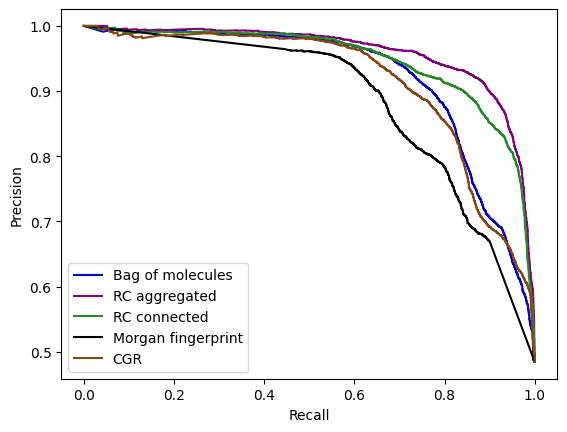

homology


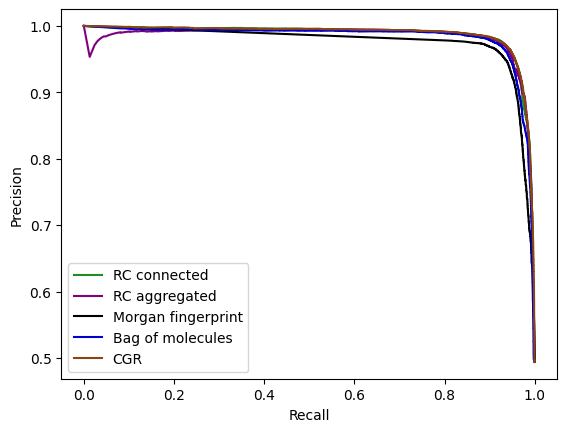

In [67]:
# PRC

for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots()
    for i, row in top_models.loc[top_models['data/split_strategy'] == strat, ['Run ID', 'model/name']].iterrows():
        pred = preds[row["Run ID"]]
        prec, recall, _ = precision_recall_curve(pred['y'], pred['logits'])
        # auprc_manual = auc(recall, prec)
        ax.plot(recall, prec, color=colors[row['model/name']], label=labels[row['model/name']])
        
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    plt.savefig(save_to / f"prc_{strat}.svg")
    plt.show()

rcmcs


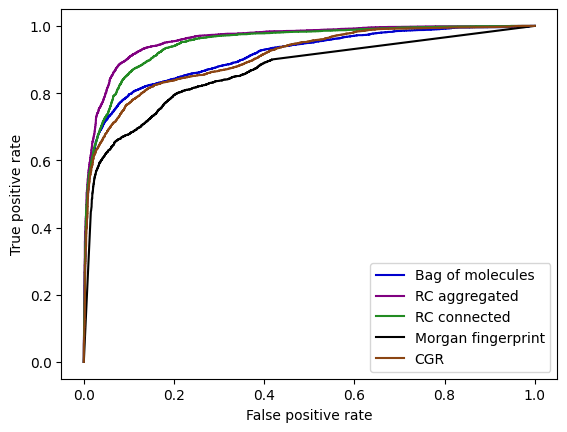

homology


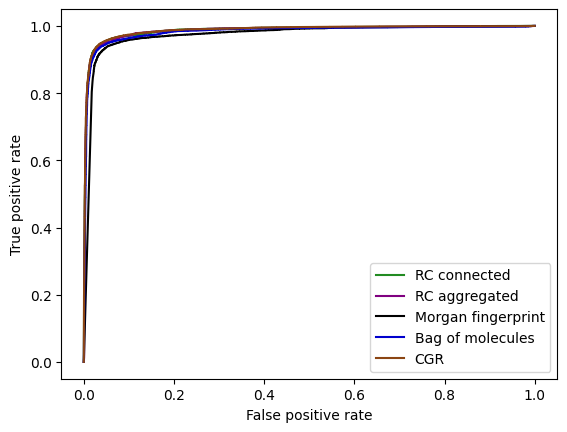

In [68]:
# ROC

for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots()
    for i, row in top_models.loc[top_models['data/split_strategy'] == strat, ['Run ID', 'model/name']].iterrows():
        pred = preds[row["Run ID"]]
        fpr, tpr, _ = roc_curve(pred['y'], pred['logits'])
        ax.plot(fpr, tpr, color=colors[row['model/name']], label=labels[row['model/name']])
        
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.legend()
    plt.savefig(save_to / f"roc_{strat}.svg")
    plt.show()

rcmcs


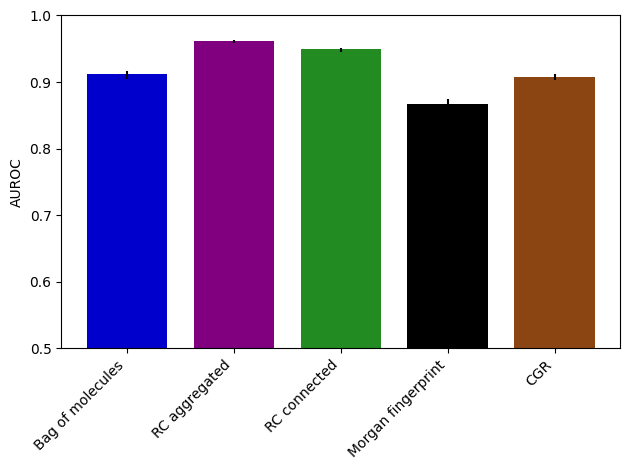

homology


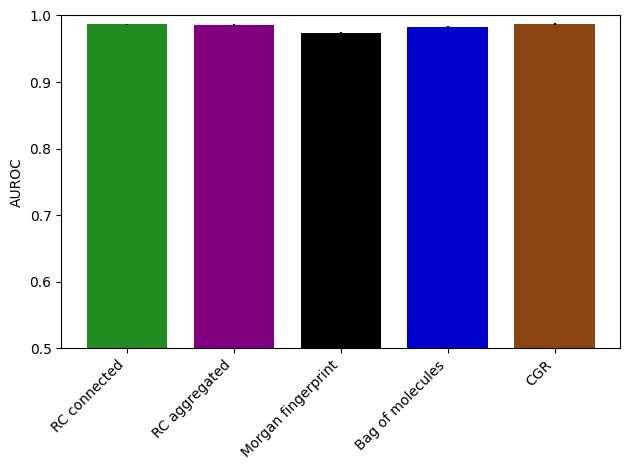

In [69]:
# TODO: AUROC bar chart
# AUROC bar chart
x = {mn: i for i, mn in enumerate(labels)}
figsize = (10, 3.5)
width = 0.75  # the width of the bars
xtick_rot = 45
xtick_ha = 'right'
ylim = (0.5, 1.0)
for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots()
    for i, row in top_models.loc[top_models['data/split_strategy'] == strat, ['Run ID', 'model/name']].iterrows():
        eval = evals[row["Run ID"]]
        auroc, (lb, ub) = eval['roc_auc']
        ci = np.array([auroc - lb, ub - auroc]).reshape(2, 1)
        ax.bar(labels[row['model/name']], height=auroc, width=width, yerr=ci, color=colors[row['model/name']])
        
    ax.set_ylabel("AUROC")
    ax.set_ylim(ylim)
    for label in ax.get_xticklabels():
        label.set_rotation(xtick_rot)
        label.set_ha(xtick_ha)
    plt.tight_layout()
    plt.savefig(save_to / f"auroc_{strat}.svg")
    plt.show()


Top models inner val metrics with test overlay

In [70]:
# Bar chart constants

x = {mn: i for i, mn in enumerate(labels)}
figsize = (10, 3.5)
width = 0.75  # the width of the bars
xtick_rot = 45
xtick_ha = 'right'
ylim = (0.5, 1.0)

rcmcs


Model: bom, Threshold: 0.010101010101010102
Model: rc_agg, Threshold: 0.010101010101010102
Model: rc_cxn, Threshold: 0.010101010101010102
Model: mfp, Threshold: 0.010101010101010102
Model: cgr, Threshold: 0.010101010101010102


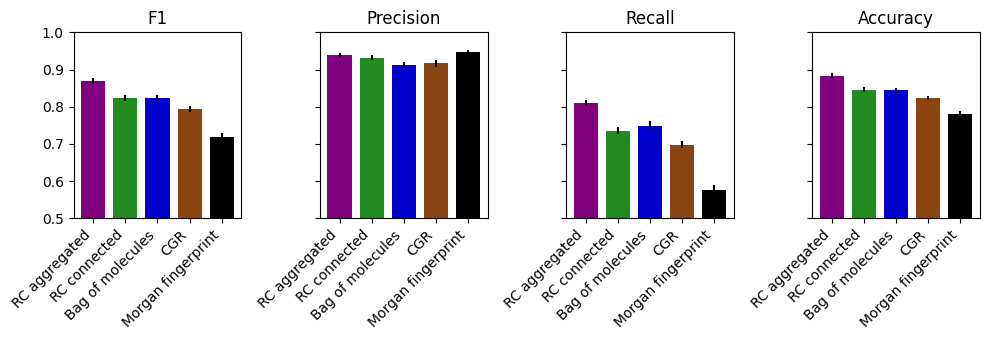

homology
Model: rc_cxn, Threshold: 0.15151515151515152
Model: rc_agg, Threshold: 0.12121212121212122
Model: mfp, Threshold: 0.05050505050505051
Model: bom, Threshold: 0.26262626262626265
Model: cgr, Threshold: 0.21212121212121213


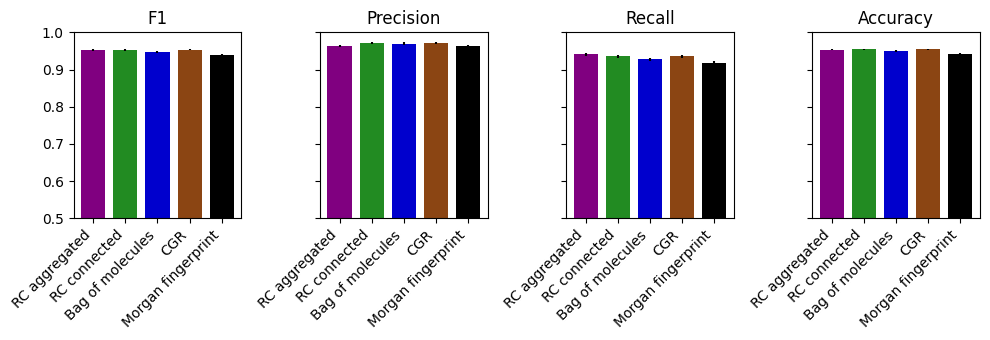

In [71]:
for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots(ncols=len(metrics), figsize=figsize, sharey=True)
    for j, row in top_models.loc[top_models['data/split_strategy'] == strat].iterrows():
        model_name = row['model/name']
        oid = row['Run ID']
        th = best_thresholds.get(oid, 0.5)
        print(f"Model: {model_name}, Threshold: {th}")
        outer_pred = preds[oid]
        outer_y = outer_pred['y']
        outer_ypred = (outer_pred['logits'] > th).astype(int)
        eval = evals[oid]
        for i, (metric_k, metric) in enumerate(metrics.items()):
            val, (lb, ub) = eval[metric_k]
            ci = np.array([val - lb, ub - val]).reshape(2, 1)
            outer_metric = metric(outer_y, outer_ypred)
            ax[i].bar(x[model_name], height=val, width=width, yerr=ci, color=colors[model_name])

            ax[i].set_xticks(list(x.values()))
            ax[i].set_xticklabels(list(labels.values()), rotation=xtick_rot, ha=xtick_ha)
            ax[i].set_title(metric_names[metric_k])
            ax[i].set_ylim(*ylim)

    plt.tight_layout()
    plt.savefig(save_to / f"f1_prec_rec_acc_{strat}.svg")
    plt.show()
            

Performance broken down by similarity bucket

In [72]:
sim_path = Path(filepaths.results) / 'similarity_matrices'
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
similarity_metrics = [
    'rcmcs',
    'homology'
]

for sim in similarity_metrics:
    print("Doing sim analysis for", sim)
    eg = top_models.loc[top_models['data/split_strategy'] == sim, 'Run ID'].iloc[0]

    S = load_similarity_matrix(
        sim_path=sim_path,
        dataset=dataset,
        toc=toc,
        sim_metric=sim if sim != 'homology' else 'gsi'
    )
    
    if sim in ['rcmcs', 'drfp']:
        val_idx = preds[eg].loc[:, 'reaction_idx'].to_list()
    elif sim in ['homology', 'esm']:
        val_idx = preds[eg].loc[:, 'protein_idx'].to_list()

    train_idx = [i for i in range(S.shape[0]) if i not in val_idx]
    max_sims = S[:, val_idx][train_idx].max(axis=0)

    for oid in top_models.loc[top_models['data/split_strategy'] == sim, 'Run ID'].to_list():
        preds[oid]['max_sim'] = max_sims

del S

Doing sim analysis for rcmcs
Doing sim analysis for homology


In [73]:
# Clustered bar chart constants

bins = {
    'rcmcs': [
        (0.8, 1),
        (0.6, 0.8),
        (0.4, 0.6),
        (0.0, 0.4),
    ],
    'homology': [
        (0.7, 1),
        (0.4, 0.7),
        (0.3, 0.4),
        (0.0, 0.3),
    ]
}

bins2labels = lambda bins: [f"[{b[0]}, {b[1]})" for b in bins]

bar_shifts = {k: i for i, k in enumerate(labels.keys())}

width = 0.17
space = 1.03
offset = (len(labels) / 2) * width
figsize = (11, 4)
ylim = {
    'rcmcs': (0.2, 1.0),
    'homology': (0.6, 1.0),
} 

rcmcs
f1
bom 0.9401378134009826
rc_agg 0.9460002292501134
rc_cxn 0.9504582703755378
mfp 0.9135493897322617
cgr 0.940294441263495
bom 0.9214195294419266
rc_agg 0.9268948967739021
rc_cxn 0.9262488732819745
mfp 0.8675429868731169
cgr 0.9290357479231902
bom 0.793593263901149
rc_agg 0.845665704868782
rc_cxn 0.8298984810479593
mfp 0.8239143313657173
cgr 0.7824737740635679
bom 0.662867120862882
rc_agg 0.7810153996611742
rc_cxn 0.6275802407893756
mfp 0.3317390628917382
cgr 0.5542996711420022


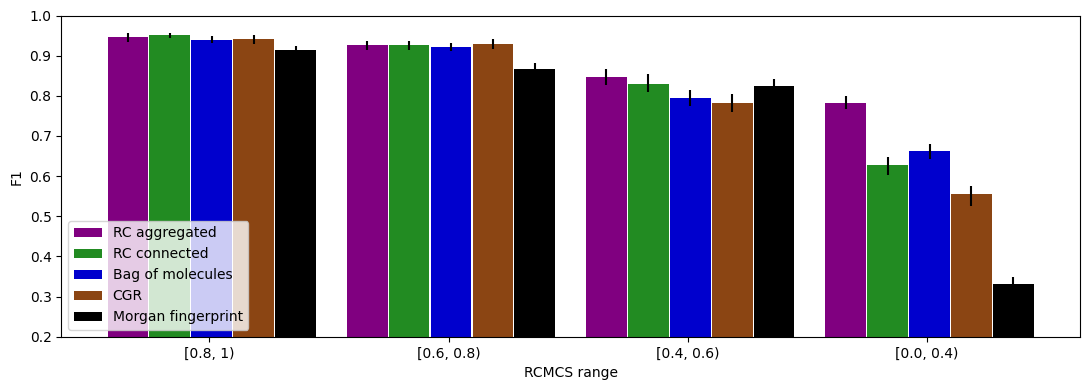

binary_precision
bom 0.9149237939621315
rc_agg 0.946396769334246
rc_cxn 0.9474377706688207
mfp 0.9603066942267303
cgr 0.9299145623122133
bom 0.915453385974434
rc_agg 0.9360529360352197
rc_cxn 0.9388902591129366
mfp 0.9477926889800418
cgr 0.9317888809052342
bom 0.8980020971158664
rc_agg 0.9213376829376654
rc_cxn 0.9143715006195724
mfp 0.9392703757135729
cgr 0.9006100486289143
bom 0.9149916220262158
rc_agg 0.9380444107999906
rc_cxn 0.9135875722922564
mfp 0.91822964470226
cgr 0.8901048388631707


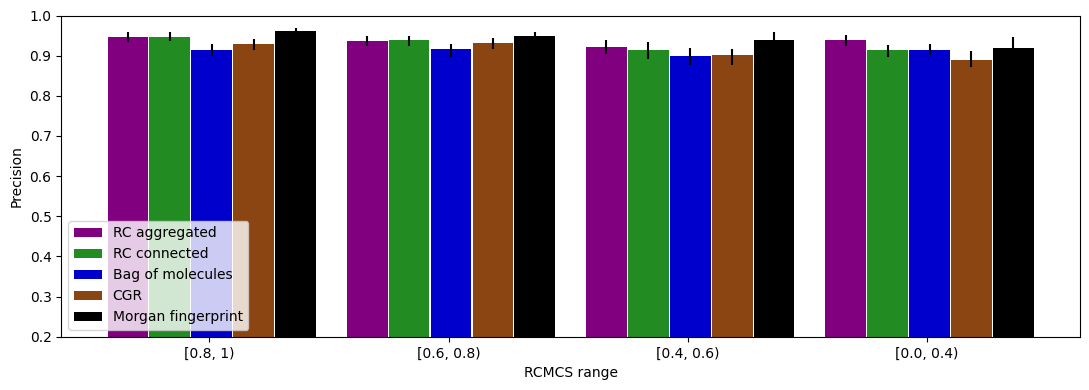

binary_recall
bom 0.9678296232960268
rc_agg 0.9424561872541085
rc_cxn 0.9526521272099212
mfp 0.8723077983254531
cgr 0.9516909447615111
bom 0.9269607555044814
rc_agg 0.9237916757102854
rc_cxn 0.9145086321141401
mfp 0.7991279726633935
cgr 0.925146169738857
bom 0.7069145906515982
rc_agg 0.7889546697974525
rc_cxn 0.7560746092522558
mfp 0.7303739865729336
cgr 0.6965397675428848
bom 0.5162530752055158
rc_agg 0.6690715059848782
rc_cxn 0.4783856744886106
mfp 0.20300676243796134
cgr 0.4022982536283677


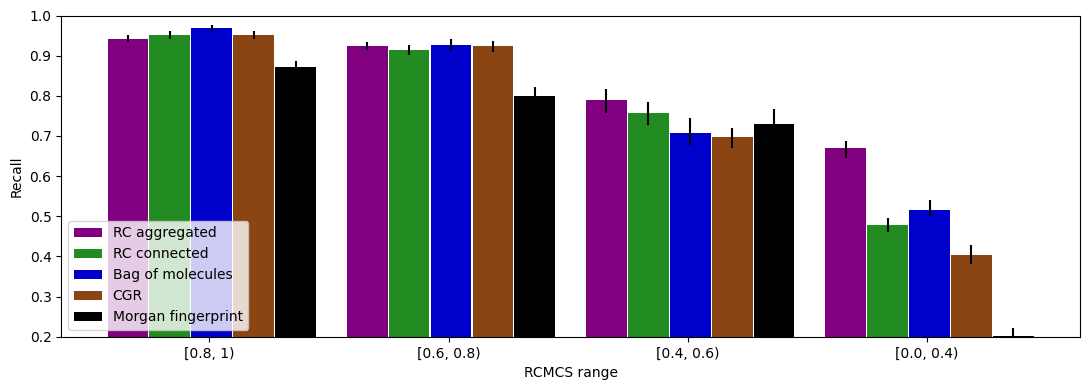

accuracy
bom 0.9472884168602722
rc_agg 0.9540192499170261
rc_cxn 0.9569731164951876
mfp 0.9304414205111187
cgr 0.9509790906073681
bom 0.9285214747244395
rc_agg 0.9374762447738502
rc_cxn 0.9352945648042568
mfp 0.89096921322691
cgr 0.9379095400988217
bom 0.8344291691572026
rc_agg 0.8736640765092646
rc_cxn 0.8649611476389718
mfp 0.860011954572624
cgr 0.8294321578003587
bom 0.6886825817860301
rc_agg 0.7798290598290598
rc_cxn 0.6663129973474803
mfp 0.518821102269378
cgr 0.6206130268199235


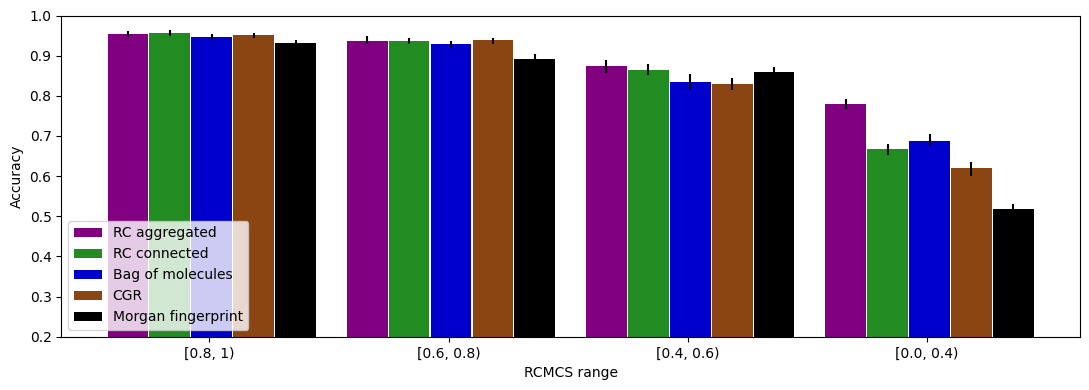

homology
f1
rc_cxn 0.9882639943793271
rc_agg 0.9872664370327443
mfp 0.9840658369518462
bom 0.9894731677745331
cgr 0.9913889258180701
rc_cxn 0.9715854748045794
rc_agg 0.9647297558902385
mfp 0.9567216721994921
bom 0.9693439282024282
cgr 0.9711314408873574
rc_cxn 0.9396150541460812
rc_agg 0.9404009227750393
mfp 0.9233005778010527
bom 0.9326728719264247
cgr 0.943047915819274
rc_cxn 0.9474772638945064
rc_agg 0.9479372305052243
mfp 0.93573180705437
bom 0.9418073749859103
cgr 0.9470416899712275


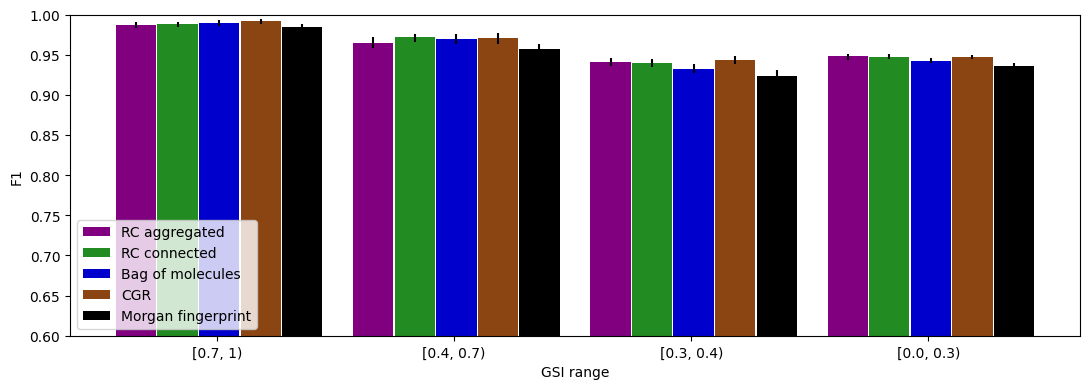

binary_precision
rc_cxn 0.9778208419327266
rc_agg 0.9747856903741983
mfp 0.9734092585227608
bom 0.9804113625383728
cgr 0.9830087685063595
rc_cxn 0.97387975270909
rc_agg 0.9667729366814699
mfp 0.9585758505514357
bom 0.974386470781655
cgr 0.9765308425098844
rc_cxn 0.9595188511245466
rc_agg 0.95273623652307
mfp 0.9480789236822337
bom 0.956646001176251
cgr 0.9601864895370068
rc_cxn 0.9736497836325665
rc_agg 0.9658530191917005
mfp 0.9662625018318274
bom 0.9710944545611203
cgr 0.9745153282609652


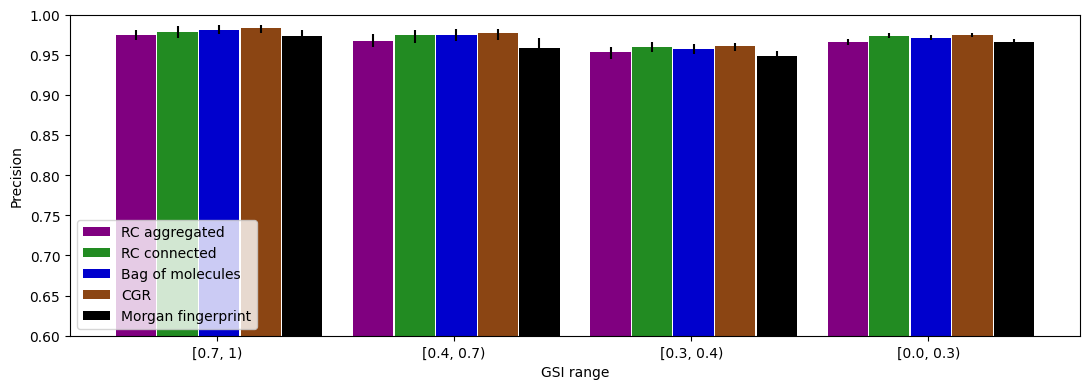

binary_recall
rc_cxn 0.9993083349478242
rc_agg 1.0
mfp 0.9946075856768049
bom 0.9993503030416617
cgr 1.0
rc_cxn 0.9678199177506811
rc_agg 0.9652669315595781
mfp 0.9538143341910441
bom 0.9646271132736102
cgr 0.9673616073190793
rc_cxn 0.921910492751898
rc_agg 0.9266111871551073
mfp 0.8965996643233097
bom 0.9098997843154385
cgr 0.927651918726432
rc_cxn 0.9225067894591257
rc_agg 0.9306328336351369
mfp 0.9063344779941674
bom 0.9133090517473434
cgr 0.9206295001951222


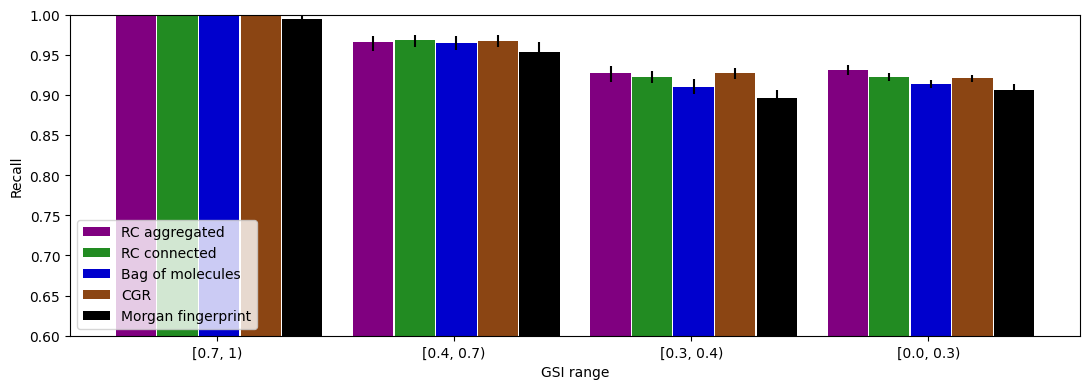

accuracy
rc_cxn 0.9864678404599354
rc_agg 0.9856701401365433
mfp 0.9821559468199784
bom 0.9888393819619116
cgr 0.9907294286740926
rc_cxn 0.9717377049180327
rc_agg 0.9657850637522769
mfp 0.9575373406193078
bom 0.9704699453551912
cgr 0.9718615664845173
rc_cxn 0.9484150843881856
rc_agg 0.9483175105485232
mfp 0.9337790084388184
bom 0.9428612869198312
cgr 0.9507964135021096
rc_cxn 0.9475661650233522
rc_agg 0.9474974052932019
mfp 0.9349571873378308
bom 0.9415762843798651
cgr 0.9464244940321742


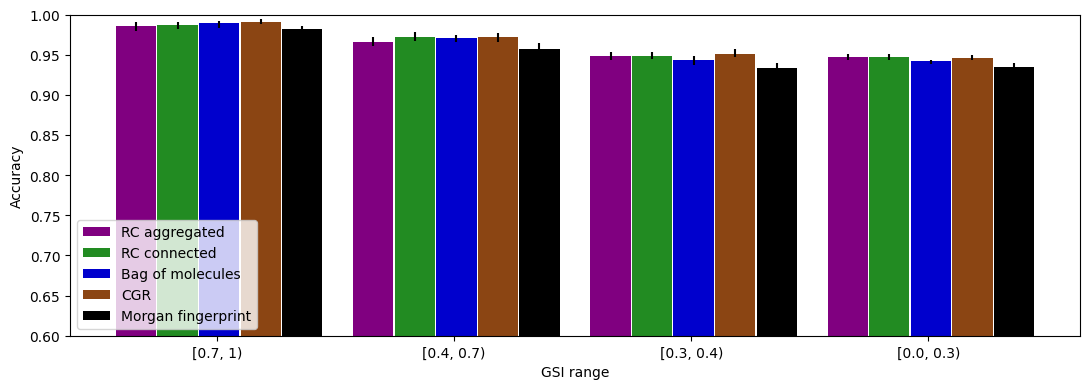

In [74]:
for strat in split_strategies:
    print(strat)
    x = [i for i in range(len(bins[strat]))]
    for metric_k, metric in discrete_metrics.items():
        print(metric_k)
        fig, ax = plt.subplots(figsize=figsize, sharey=True)
        for i, (lb, ub) in enumerate(bins[strat]):
            for _, row in top_models.loc[top_models['data/split_strategy'] == strat].iterrows():
                model_name = row['model/name']
                oid = row['Run ID']
                th = best_thresholds.get(oid, 0.5)
                pred = preds[oid]
                pred = pred.loc[(pred['max_sim'] < ub) & (pred['max_sim'] >= lb)]

                val, (lci, uci) = metric(pred['y'].to_numpy(), pred['logits'].to_numpy(), threshold=th)
                
                ci = np.array([val - lci, uci - val]).reshape(2, 1)

                ax.bar(x=x[i] - offset + width * bar_shifts[model_name] * space, height=val, yerr=ci, width=width, color=colors[model_name])
                print(model_name, val)
            
        for key in labels:
            ax.bar(0, 0, color=colors[key], label=labels[key])
        
        ax.set_ylim(*ylim[strat])
        ax.set_xticks(np.array(x) - width / 2)
        ax.set_xticklabels(bins2labels(bins[strat]))
        ax.set_ylabel(metric_names[metric_k])
        ax.set_xlabel(f"{similarity_names[strat]} range")
        ax.legend(loc='lower left')
        plt.tight_layout()
        plt.savefig(save_to / f"{strat}_similarity_clustered_{metric_names[metric_k]}.svg")
        plt.show()